In [1]:
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

import sys
sys.path.insert(0, "../")

In [2]:
from data_iq.dataiq_class import *
from src.utils.utils import *
from src.models.neuralnets import *
from src.utils.data_loader import *

In [3]:
dataset = "covid"

(
    train_loader,
    train_data,
    X_train,
    y_train,
    X_test,
    y_test,
    X_train_pd,
    y_train_pd,
    X_test_pd,
    y_test_pd,
    nlabels,
    corr_vals,
    column_ids,
    df,
) = load_dataset(dataset)

n_feats = X_train.shape[1]
nlabels = len(np.unique(y_train))

# Train neural nets & assess with Data-IQ

In [4]:
LEARNING_RATE = 0.001
EPOCHS = 20
dataiq_list = []
test_perf = []
nets = [
    Net1(input_size=n_feats, nlabels=nlabels),
    Net2(input_size=n_feats, nlabels=nlabels),
    Net3(input_size=n_feats, nlabels=nlabels),
    Net4(input_size=n_feats, nlabels=nlabels),
]
checkpoint_list = []


for net_idx in range(4):

    from aum import DatasetWithIndex

    train_loader = DataLoader(
        dataset=DatasetWithIndex(train_data), batch_size=128, shuffle=True
    )
    ckpt_nets = []
    net = nets[net_idx]
    net.to(device)
    criterion = torch.nn.NLLLoss()

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    dataiq = DataIQ_Torch(X=X_train, y=y_train, sparse_labels=True)

    for e in range(1, EPOCHS + 1):
        net.train()
        epoch_loss = 0
        epoch_acc = 0
        for X_batch, y_batch, sample_ids in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            sf = nn.LogSoftmax()
            y_pred = net(X_batch)

            _, predicted = torch.max(y_pred.data, 1)

            y_batch = y_batch.to(torch.int64)

            loss = criterion(sf(y_pred), y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += (predicted == y_batch).sum().item() / len(y_batch)

        dataiq.on_epoch_end(net, device=device)
        print(
            f"Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}"
        )
        ckpt_nets.append(deepcopy(net))

    net.eval()
    with torch.no_grad():
        X_batch = torch.FloatTensor(X_test).to(device)
        X_batch = X_batch.to(device)
        y_test_pred = net(X_batch)

        try:
            y_batch = torch.LongTensor(y_test).to(device)
        except:
            y_test = y_test.values
            y_batch = torch.LongTensor(y_test).to(device)
           
        _, predicted = torch.max(y_test_pred.data, 1)

        y_batch = y_batch.to(torch.int64)

        loss_test = criterion(sf(y_test_pred), torch.LongTensor(y_test).to(device))

        acc = (predicted == y_batch).sum().item() / len(y_batch)
        test_perf.append(acc)
        print("Test: ", loss_test.item())

    checkpoint_list.append(ckpt_nets)
    dataiq_list.append(dataiq)

/content/src/models/neuralnets.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 001: | Loss: 0.70475 | Acc: 0.469
Epoch 002: | Loss: 0.69106 | Acc: 0.498
Epoch 003: | Loss: 0.64570 | Acc: 0.683
Epoch 004: | Loss: 0.59740 | Acc: 0.702
Epoch 005: | Loss: 0.58605 | Acc: 0.712
Epoch 006: | Loss: 0.57047 | Acc: 0.727
Epoch 007: | Loss: 0.56493 | Acc: 0.736
Epoch 008: | Loss: 0.56611 | Acc: 0.727
Epoch 009: | Loss: 0.56769 | Acc: 0.726
Epoch 010: | Loss: 0.56144 | Acc: 0.736
Epoch 011: | Loss: 0.55709 | Acc: 0.740
Epoch 012: | Loss: 0.55932 | Acc: 0.740
Epoch 013: | Loss: 0.55584 | Acc: 0.746
Epoch 014: | Loss: 0.56754 | Acc: 0.729
Epoch 015: | Loss: 0.55656 | Acc: 0.743
Epoch 016: | Loss: 0.55584 | Acc: 0.741
Epoch 017: | Loss: 0.56202 | Acc: 0.738
Epoch 018: | Loss: 0.55631 | Acc: 0.740
Epoch 019: | Loss: 0.55492 | Acc: 0.743
Epoch 020: | Loss: 0.55698 | Acc: 0.747
Test:  0.575952410697937


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/content/src/models/neuralnets.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))


Epoch 001: | Loss: 0.69971 | Acc: 0.474
Epoch 002: | Loss: 0.68379 | Acc: 0.516
Epoch 003: | Loss: 0.65097 | Acc: 0.682
Epoch 004: | Loss: 0.60570 | Acc: 0.709
Epoch 005: | Loss: 0.58183 | Acc: 0.721
Epoch 006: | Loss: 0.57540 | Acc: 0.722
Epoch 007: | Loss: 0.56961 | Acc: 0.732
Epoch 008: | Loss: 0.56669 | Acc: 0.733
Epoch 009: | Loss: 0.56664 | Acc: 0.728
Epoch 010: | Loss: 0.56284 | Acc: 0.739
Epoch 011: | Loss: 0.56450 | Acc: 0.734
Epoch 012: | Loss: 0.56125 | Acc: 0.739
Epoch 013: | Loss: 0.55960 | Acc: 0.741
Epoch 014: | Loss: 0.56469 | Acc: 0.732
Epoch 015: | Loss: 0.56152 | Acc: 0.735
Epoch 016: | Loss: 0.55949 | Acc: 0.741
Epoch 017: | Loss: 0.56624 | Acc: 0.728
Epoch 018: | Loss: 0.55481 | Acc: 0.745
Epoch 019: | Loss: 0.55671 | Acc: 0.742
Epoch 020: | Loss: 0.55785 | Acc: 0.743
Test:  0.5652264356613159


/content/src/models/neuralnets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))


Epoch 001: | Loss: 0.68823 | Acc: 0.560
Epoch 002: | Loss: 0.68036 | Acc: 0.578
Epoch 003: | Loss: 0.64216 | Acc: 0.655
Epoch 004: | Loss: 0.60537 | Acc: 0.686
Epoch 005: | Loss: 0.58354 | Acc: 0.716
Epoch 006: | Loss: 0.57330 | Acc: 0.727
Epoch 007: | Loss: 0.57053 | Acc: 0.725
Epoch 008: | Loss: 0.57400 | Acc: 0.722
Epoch 009: | Loss: 0.56652 | Acc: 0.731
Epoch 010: | Loss: 0.57480 | Acc: 0.720
Epoch 011: | Loss: 0.56115 | Acc: 0.740
Epoch 012: | Loss: 0.56202 | Acc: 0.735
Epoch 013: | Loss: 0.57196 | Acc: 0.724
Epoch 014: | Loss: 0.56177 | Acc: 0.738
Epoch 015: | Loss: 0.56431 | Acc: 0.731
Epoch 016: | Loss: 0.56170 | Acc: 0.735
Epoch 017: | Loss: 0.55953 | Acc: 0.740
Epoch 018: | Loss: 0.55527 | Acc: 0.746
Epoch 019: | Loss: 0.55809 | Acc: 0.739
Epoch 020: | Loss: 0.55863 | Acc: 0.739
Test:  0.5655510425567627


/content/src/models/neuralnets.py:87: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = F.softmax(self.output(X))


Epoch 001: | Loss: 0.75440 | Acc: 0.530
Epoch 002: | Loss: 0.68855 | Acc: 0.508
Epoch 003: | Loss: 0.67809 | Acc: 0.583
Epoch 004: | Loss: 0.65842 | Acc: 0.684
Epoch 005: | Loss: 0.63150 | Acc: 0.696
Epoch 006: | Loss: 0.60987 | Acc: 0.710
Epoch 007: | Loss: 0.59651 | Acc: 0.712
Epoch 008: | Loss: 0.59019 | Acc: 0.711
Epoch 009: | Loss: 0.58988 | Acc: 0.710
Epoch 010: | Loss: 0.57851 | Acc: 0.721
Epoch 011: | Loss: 0.57394 | Acc: 0.726
Epoch 012: | Loss: 0.56969 | Acc: 0.732
Epoch 013: | Loss: 0.57253 | Acc: 0.725
Epoch 014: | Loss: 0.56703 | Acc: 0.732
Epoch 015: | Loss: 0.56595 | Acc: 0.732
Epoch 016: | Loss: 0.56317 | Acc: 0.739
Epoch 017: | Loss: 0.56517 | Acc: 0.736
Epoch 018: | Loss: 0.56058 | Acc: 0.742
Epoch 019: | Loss: 0.56124 | Acc: 0.735
Epoch 020: | Loss: 0.56112 | Acc: 0.739
Test:  0.5666326880455017


# Train XGB, CATBOOST, LIGHTGBM & Assess with Data-IQ

In [5]:
accs = {}

if dataset=='fetal':
  nest=10
  idx=0

if dataset=='covid':
  nest = 20
  idx=0

if dataset=='support':
  nest = 10
  idx=2 #3 

if dataset=='prostate':
  nest = 50
  idx=2 #3 

################################################################
# XGB
################################################################

# TRAIN XGB
clf = xgb.XGBClassifier(n_estimators=nest)
clf.fit(X_train, y_train)
accs["xgb"] = round(accuracy_score(clf.predict(X_test), y_test), 2)

# Compute XGB Data-IQ
dataiq_xgb = DataIQ_SKLearn(X=X_train, y=y_train)
for i in range(1, nest):
    dataiq_xgb.on_epoch_end(clf=clf, iteration=i)

################################################################
# LIGHTGBM
################################################################

# TRAIN LIGHTGBM
clf = LGBMClassifier(n_estimators=nest)
clf.fit(X_train, y_train)
accs['gbm'] = round(accuracy_score(clf.predict(X_test),y_test),2)

# Compute GBM Data-IQ
dataiq_gbm = DataIQ_SKLearn(X=X_train, y=y_train)
for i in range(1,nest):
  dataiq_gbm.on_epoch_end(clf=clf, iteration=i)


################################################################
# CATBOOST
################################################################

# TRAIN CATBOOST
clf = CatBoostClassifier(n_estimators=nest)
clf.fit(X_train, y_train)
accs['cat'] = round(accuracy_score(clf.predict(X_test),y_test),2)

# Compute Catbosot Data-IQ
dataiq_catboost = DataIQ_SKLearn(X=X_train, y=y_train, catboost=True)
for i in range(1,nest):
  dataiq_catboost.on_epoch_end(clf=clf, iteration=i)

Learning rate set to 0.5
0:	learn: 0.5855074	total: 48.9ms	remaining: 930ms
1:	learn: 0.5606682	total: 51.9ms	remaining: 467ms
2:	learn: 0.5391055	total: 54.6ms	remaining: 309ms
3:	learn: 0.5304388	total: 57.1ms	remaining: 228ms
4:	learn: 0.5189307	total: 59.7ms	remaining: 179ms
5:	learn: 0.5083918	total: 62.3ms	remaining: 145ms
6:	learn: 0.5043188	total: 64.8ms	remaining: 120ms
7:	learn: 0.4993829	total: 67.5ms	remaining: 101ms
8:	learn: 0.4964756	total: 70.1ms	remaining: 85.6ms
9:	learn: 0.4897466	total: 72.7ms	remaining: 72.7ms
10:	learn: 0.4871252	total: 75.2ms	remaining: 61.6ms
11:	learn: 0.4842256	total: 77.8ms	remaining: 51.9ms
12:	learn: 0.4805628	total: 80.4ms	remaining: 43.3ms
13:	learn: 0.4786467	total: 83ms	remaining: 35.6ms
14:	learn: 0.4752418	total: 85.6ms	remaining: 28.5ms
15:	learn: 0.4729843	total: 88.1ms	remaining: 22ms
16:	learn: 0.4677579	total: 90.8ms	remaining: 16ms
17:	learn: 0.4633731	total: 93.4ms	remaining: 10.4ms
18:	learn: 0.4600394	total: 96ms	remaining: 5

In [8]:
accs['nn'] = round(test_perf[idx], 2)

combos = [
    ("nn", "xgb"),
    ("nn", "cat"),
    ("nn", "gbm"),
    ("xgb", "cat"),
    ("xgb", "gbm"),
    ("cat", "gbm"),
]
overall = {}


mappers = {
    "nn": dataiq_list[idx],
    "xgb": dataiq_xgb,
    "cat": dataiq_catboost,
    "gbm": dataiq_gbm,
}

scores_dataiq = []
scores_datamap = []
for combo in combos:

    out = compare_model_classes(model1=mappers[combo[0]], model2=mappers[combo[1]])
    scores_dataiq.append(out[5])

    out = compare_model_classes(
        model1=mappers[combo[0]], model2=mappers[combo[1]], feat="variability"
    )
    scores_datamap.append(out[5])

print('Correlations:\\')
print(f"Data-IQ: {np.mean(scores_dataiq)}+-{np.std(scores_dataiq)}")
print(f"Data Maps: {np.mean(scores_datamap)}+-{np.std(scores_datamap)}")

Correlations:\
Data-IQ: 0.8727407049925356+-0.04652139517427754
Data Maps: 0.5006766505553745+-0.10661980021055303


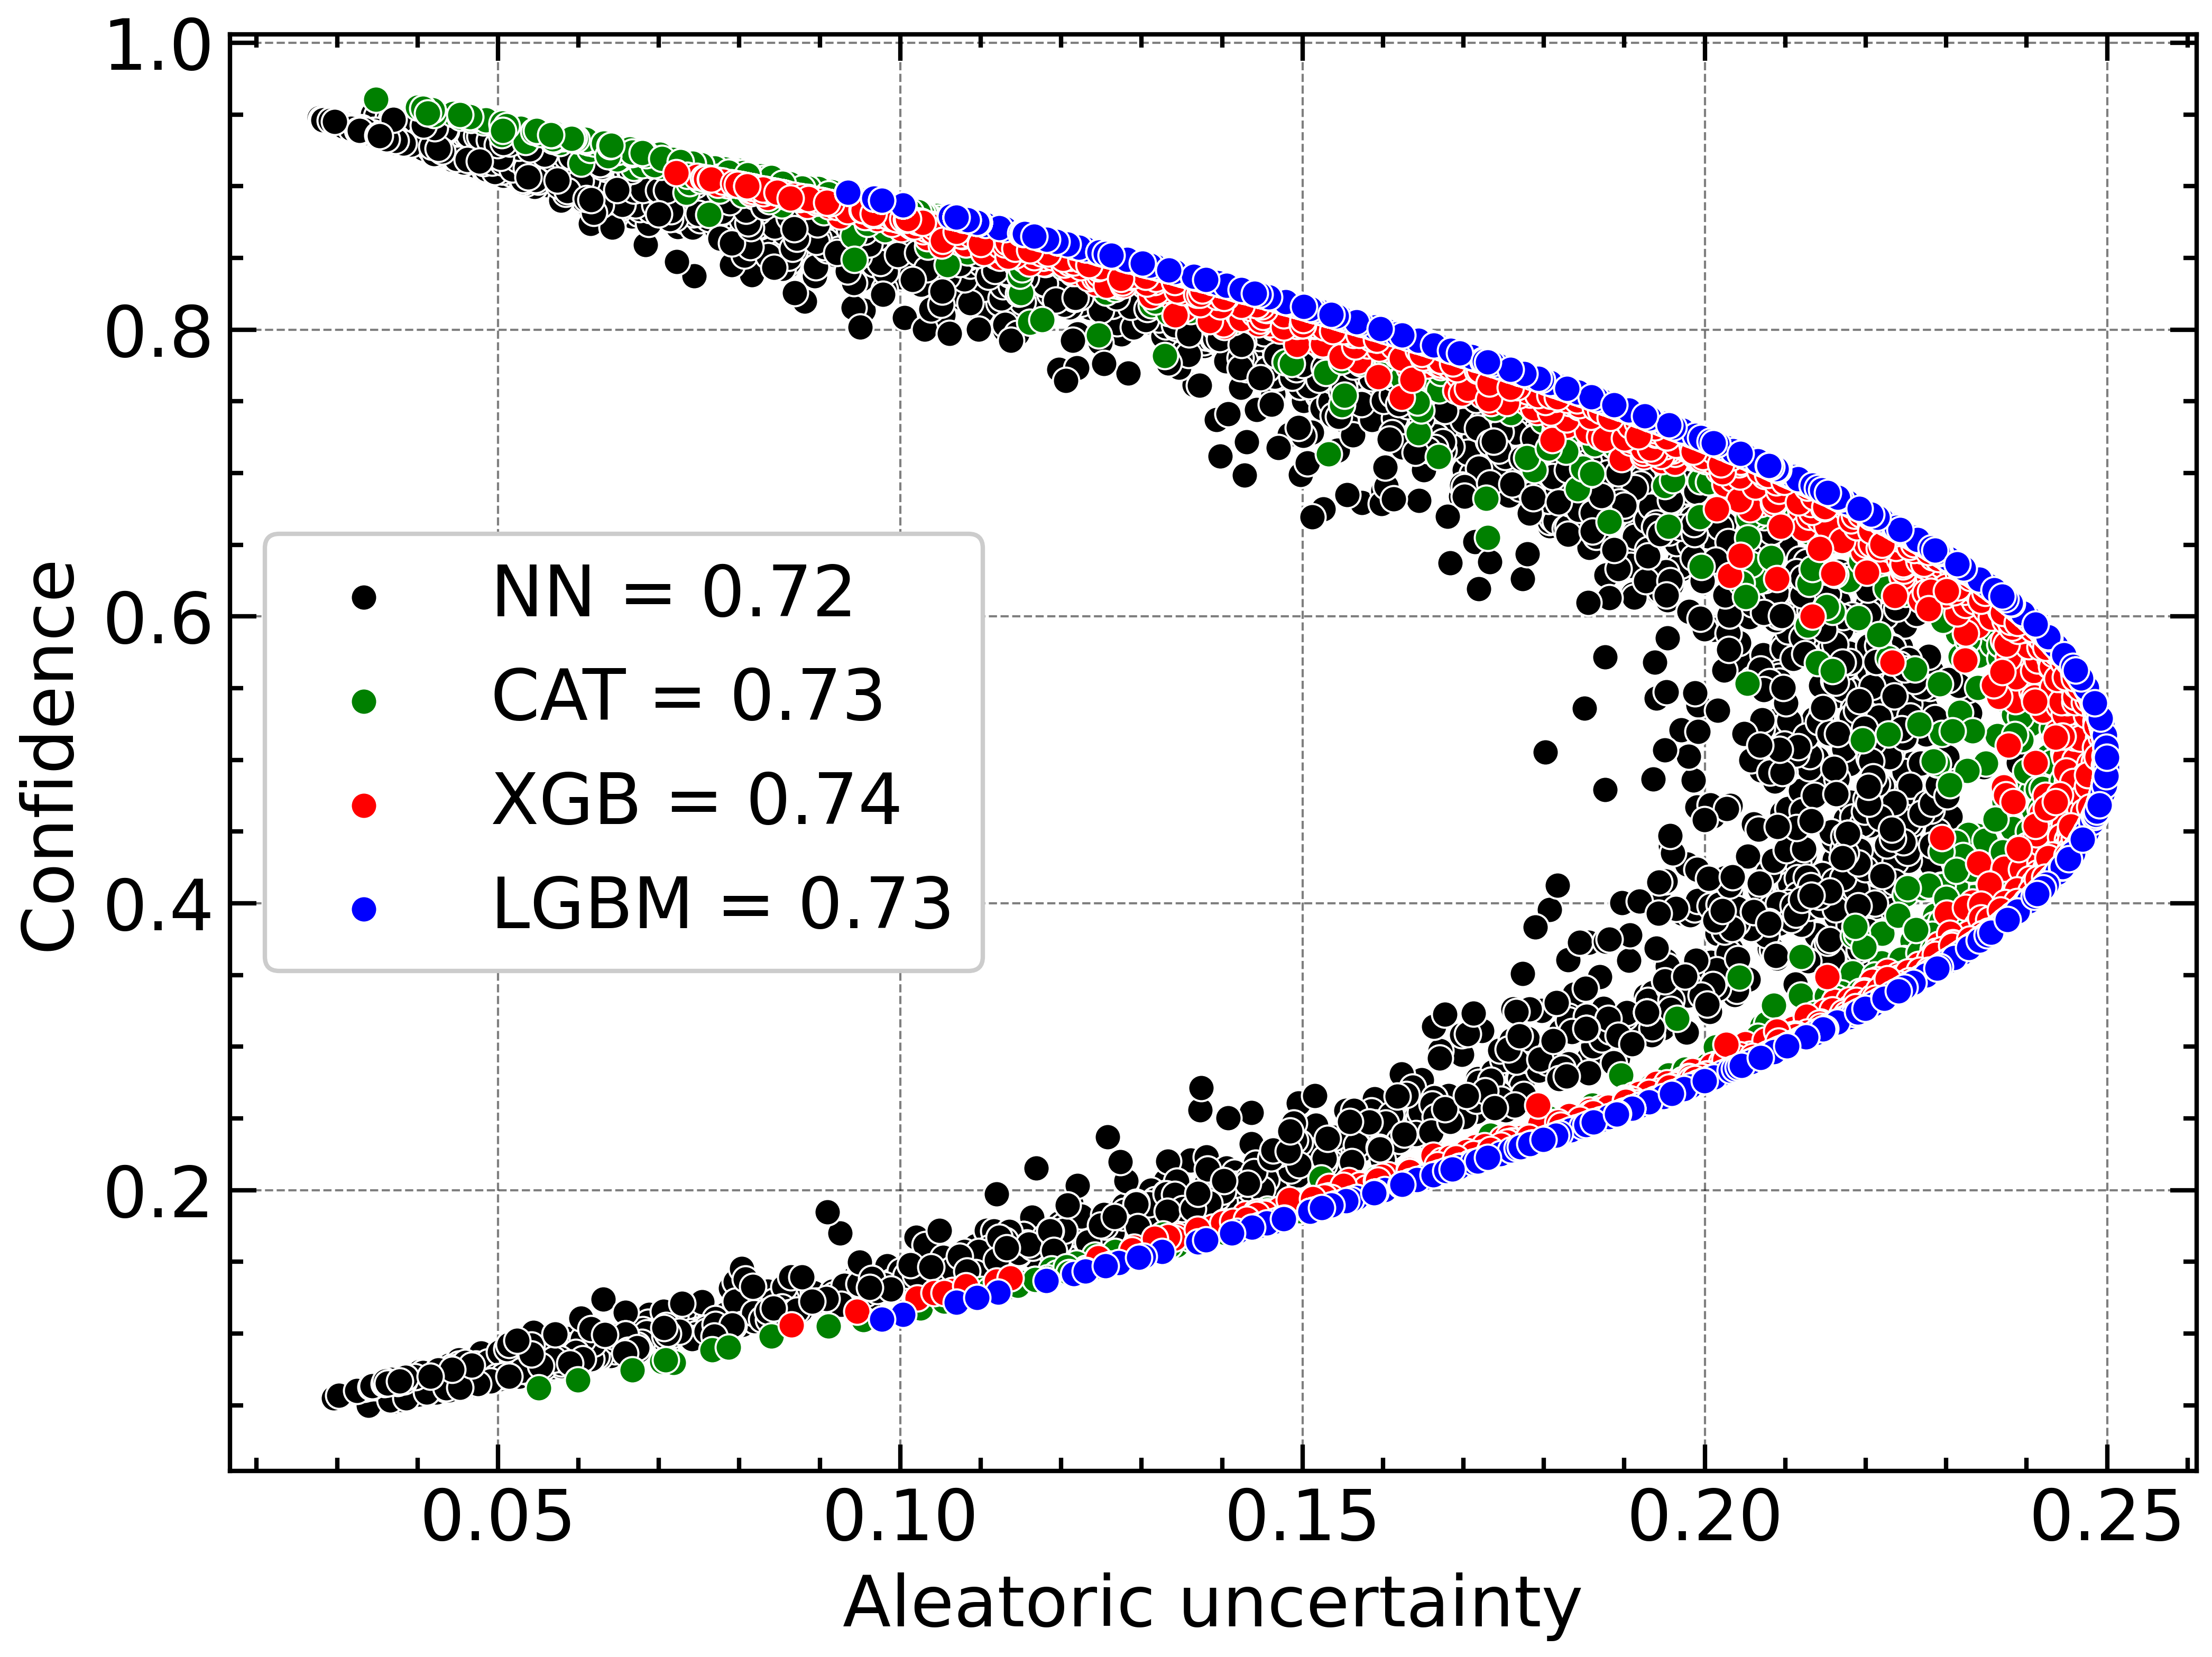

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.reload_library()
plt.style.use(["science", "ieee", "no-latex", "notebook", "grid", "vibrant"])


accs["nn"] = round(test_perf[idx], 2)
sns.scatterplot(
    x=dataiq_list[idx].aleatoric,
    y=dataiq_list[idx].confidence,
    color="k",
    label=f"NN = {accs['nn']}",
)

sns.scatterplot(x=dataiq_catboost.aleatoric, 
                y=dataiq_catboost.confidence, 
                color='g', 
                label= f"CAT = {accs['cat']}")


sns.scatterplot(
    x=dataiq_xgb.aleatoric,
    y=dataiq_xgb.confidence,
    color="r",
    label=f"XGB = {accs['xgb']}",
)

sns.scatterplot(x=dataiq_gbm.aleatoric, 
                y=dataiq_gbm.confidence, 
                color='b', 
                label=f"LGBM = {accs['gbm']}")



plt.xlabel("Aleatoric uncertainty")
plt.ylabel("Confidence")
plt.show()

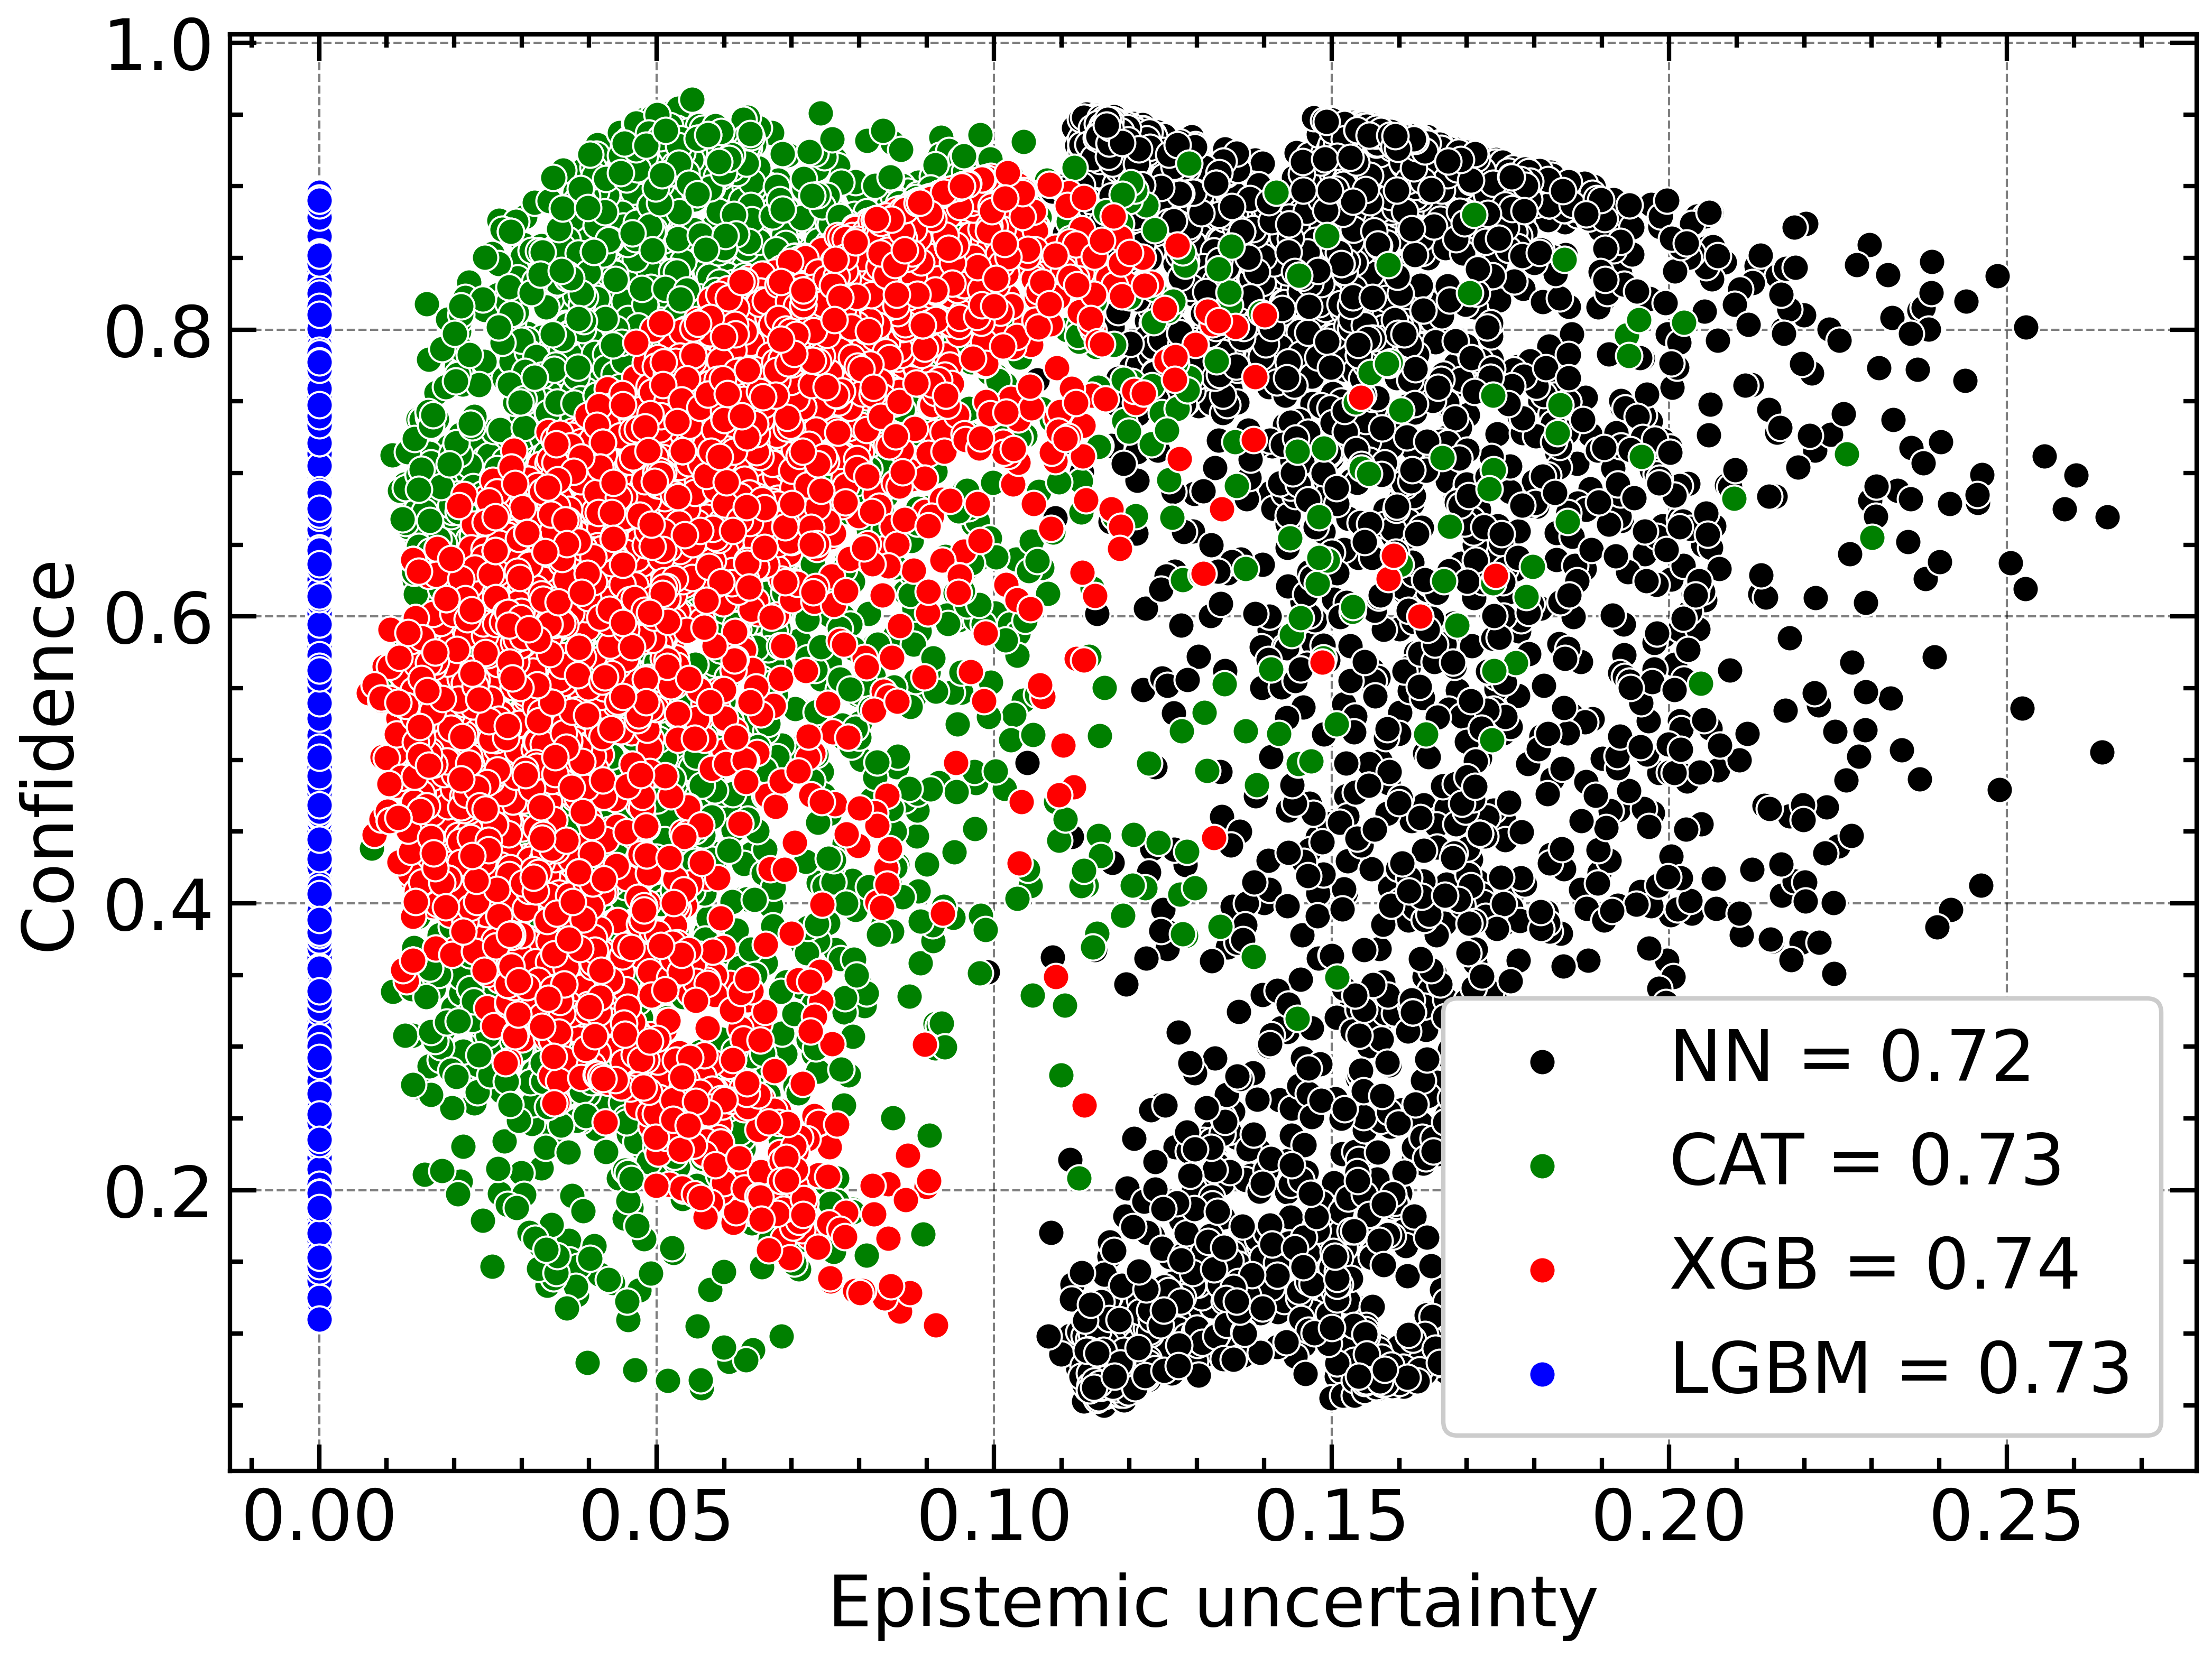

In [10]:
sns.scatterplot(
    x=dataiq_list[idx].variability,
    y=dataiq_list[idx].confidence,
    color="k",
    label=f"NN = {accs['nn']}",
)

sns.scatterplot(
    x=dataiq_catboost.variability, 
    y=dataiq_catboost.confidence, 
    color='g', 
    label= f"CAT = {accs['cat']}")


sns.scatterplot(
    x=dataiq_xgb.variability,
    y=dataiq_xgb.confidence,
    color="r",
    label=f"XGB = {accs['xgb']}",
)

sns.scatterplot(x=dataiq_gbm.variability, 
                y=dataiq_gbm.confidence, 
                color='b', 
                label=f"LGBM = {accs['gbm']}")

plt.xlabel("Epistemic uncertainty")
plt.ylabel("Confidence")
plt.show()